# Radon-Cumulative Distribution Transform (R-CDT)

This tutorial will demonstrate: how to use the forward and inverse operations of the R-CDT in the *PyTransKit* package.

## Class:: RadonCDT
**Functions**:

1. Forward transform:
        sig1_hat = forward(x0_range, sig0, x1_range, sig1)
        
        Inputs:
        ----------------
        x0_range : 1x2 array
            contains lower and upper limits for independent variable of reference signal (sig0). Example: [0,1].
        sig0 : 2d array
            Reference signal.
        x1_range : 1x2 array
            contains lower and upper limits for independent variable of input signal (sig1). Example: [0,1].
        sig1 : 2d array
            Signal to transform.
            
        Outputs:
        ----------------
        sig1_hat : 2d array
            R-CDT of input signal sig1.
  
2. Inverse transform:
        sig1_recon = inverse(sig1_hat, sig0, x1_range)
        
        Inputs:
        ----------------
        sig1_hat : 2d array
            R-CDT of a signal sig1.
        sig0 : 2d array
            Reference signal.
        x1_range : 1x2 array
            contains lower and upper limits for independent variable of input signal (sig1). Example: [0,1].
    
        Outputs:
        ----------------
        sig1_recon : 2d array
            Reconstructed signal.
    

## Definition
### Forward Transform
Let $s(\mathbf{x}),\mathbf{x}\in\Omega_s\subset\mathbb{R}$ and $s_0(\mathbf{x}),\mathbf{x}\in\Omega_{s_0}\subset\mathbb{R}$ define a given image and a reference image, respectively, which we consider to be appropriately normalized. The forward R-CDT of $s(\mathbf{x})$ is given by the measure preserving function $\widehat{s}(t,\theta)$ that satisfies:<br>
\begin{equation}
\int_{inf(\Omega_s)}^{\widehat{s}(t,\theta)}\widetilde{s}(u,\theta)du = \int_{inf(\Omega_{s_0})}^t\widetilde{s}_0(u)du,\quad \forall\theta\in[0,\pi]
\end{equation}

where, the Radon transform of the image $s(\mathbf{x})$ is given by<br>
\begin{equation}
\widetilde{s}(t,\theta) = \int_{\Omega_s}s(\mathbf{x})\delta(t-\mathbf{x}.\xi_{\theta})d\mathbf{x},\quad \xi_{\theta} = \left[\begin{array} &\cos{(\theta)}\\ \sin{(\theta)} \end{array}\right]
\end{equation}

### Inverse Transform
The transformed signal in R-CDT space can be recovered via the following inverse formula:<br>
\begin{equation}
s(\mathbf{x})=\mathcal{R}^{-1}\left(\frac{\partial\widehat{s}^{-1}(t,\theta)}{\partial t}\widetilde{s}_0\left(\widehat{s}^{-1}(t,\theta),\theta\right)\right),
\end{equation}
where $\mathcal{R}^{-1}(.)$ denotes the inverse Radon transform.

## R-CDT Demo
The examples will cover the following operations:
* Forward and inverse operations of the R-CDT
* Classification using R-CDT

In [1]:
import sys
sys.path.append('../')

import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import radon, iradon
from pytranskit.optrans.continuous.radoncdt import RadonCDT
from pytranskit.optrans.utils import signal_to_pdf
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.ndimage import filters
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
%matplotlib inline

### Forward Radon-CDT

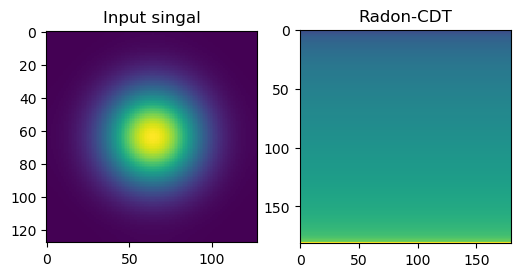

In [2]:
# Create the signal
I = np.zeros([128, 128])
I[64, 64] = 1
I = filters.gaussian_filter(I, sigma=20)

# Perform transform
x0_range = [0, 1]
x_range = [0, 1]
template=np.ones([128, 128])
radoncdt = RadonCDT()
Ihat = radoncdt.forward(x0_range, template, x_range, I)

# Plot results
fig, (ax0, ax1) = plt.subplots(ncols=2, dpi=100)
ax0.set_title('Input singal')
ax1.set_title('Radon-CDT')
ax0.imshow(I)
ax1.imshow(Ihat)
plt.show()

### Inverse Radon-CDT

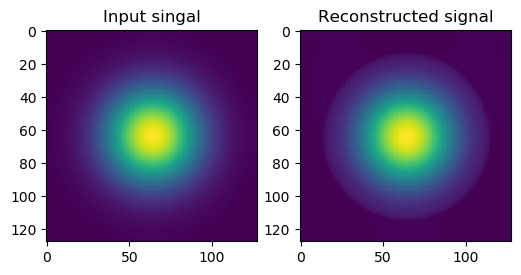

In [3]:
Irecon = radoncdt.inverse(Ihat, template, x_range)

# Plot results
fig, (ax0, ax1) = plt.subplots(ncols=2, dpi=100)
ax0.set_title('Input singal')
ax1.set_title('Reconstructed signal')
ax0.imshow(I)
ax1.imshow(Irecon)
plt.show()

plt.show()

### Classification in Radon-CDT space

In [4]:
np.random.seed(123)
# Initialize RadonCDT object
radoncdt = RadonCDT()

# Generate 3 classes of k-modal two-dimensional Gaussians
N = 100  # Number of datapoints per class
sigma = 3  # Standard deviation of each Gaussian
# Initialize
x0_range = [0, 1]
x_range = [0, 1]
I = np.zeros((3, N, 128, 128))
template = np.ones([128, 128])
#K, L = radoncdt.forward(template, I[0, 0, :, :]+1e-8).shape
K, L = radoncdt.forward(x0_range, template, x_range, I[0, 0, :, :]+1e-8).shape
Ihat = np.zeros((3, N, K, L))
Ihat = np.random.randn(3, N, K, L)
# Generate dataset
for c in range(3):
  for i in range(N):
    for _ in range(c + 1):
      x, y = np.random.uniform(30, 98, (2,)).astype('int')
      I[c, i, x, y] = 1
    I[c, i, :, :] = I[c, i, :, :] / I[c, i, :, :].sum()
    I[c, i, :, :] = filters.gaussian_filter(I[c, i, :, :], sigma=sigma)
    #Ihat[c, i, :, :] = radoncdt.forward(template, I[c, i, :, :])
    Ihat[c, i, :, :] = radoncdt.forward(x0_range, template, x_range, I[c, i, :, :])

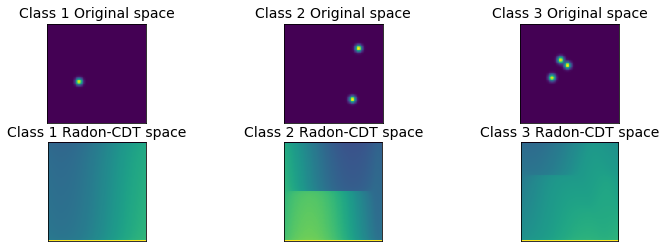

In [5]:

fig, ax = plt.subplots(2, 3, figsize=(12, 4))
title = ['Class 1', 'Class 2', 'Class 3']
for c in range(3):
  ind = np.random.randint(low=0, high=N)
  ax[0, c].imshow(I[c, ind, :, :])
  ax[0, c].set_xticks([])
  ax[0, c].set_yticks([])
  ax[0, c].set_title(title[c] + ' Original space', fontsize=14)
  ax[1, c].imshow(Ihat[c, ind, :, :])
  ax[1, c].set_xticks([])
  ax[1, c].set_yticks([])
  ax[1, c].set_title(title[c] + ' Radon-CDT space', fontsize=14)
plt.show()

/Users/ar3fx/anaconda3/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/ar3fx/anaconda3/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ar3fx/anaconda3/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


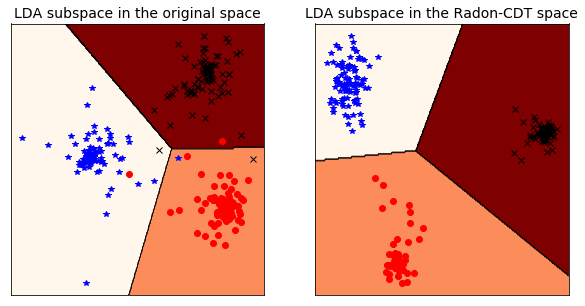

In [6]:
X=np.reshape(I,(3*N,128*128))
Xhat=np.reshape(Ihat,(3*N,K*L))
label=np.concatenate([np.ones(N), np.ones(N)+1, np.ones(N)+2])
lda=LDA(solver='svd', n_components=2)
n=N
# Apply LDA  in Signal Space
Xlda=lda.fit_transform(X,label)
svm=LinearSVC()
svm.fit(Xlda,label)
# Apply LDA in transform space 
Xhatlda=lda.fit_transform(Xhat,label)
svmhat=LinearSVC()
svmhat.fit(Xhatlda,label)
# Show classification boundaries in both Spaces
svmClassifier=[svm,svmhat]
Xdata=[Xlda,Xhatlda]
title=['LDA subspace in the original space','LDA subspace in the Radon-CDT space']
fig,ax=plt.subplots(1,2,figsize=(10,5))
for i in range(2):
    ax[i].plot(Xdata[i][:n,0],Xdata[i][:n,1],'b*')
    ax[i].plot(Xdata[i][n:2*n,0],Xdata[i][n:2*n,1],'ro')
    ax[i].plot(Xdata[i][2*n:,0],Xdata[i][2*n:,1],'kx')

    x_min, x_max = ax[i].get_xlim()
    y_min, y_max = ax[i].get_ylim()
    nx, ny = 400, 200
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = svmClassifier[i].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:].reshape(xx.shape)

    ax[i].pcolormesh(xx, yy, Z,cmap='OrRd')
    ax[i].contour(xx, yy, Z, linewidths=.5, colors='k')
    ax[i].set_title(title[i],fontsize=14)
    ax[i].set_xticks([])
    ax[i].set_yticks([])